# Análisis Posts twitter

In [1]:
# Importamos las librerías

import re
import nltk
import pandas as pd
from datetime import datetime
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from nltk.tokenize import RegexpTokenizer

import gensim
from gensim import corpora
from gensim.models import LdaModel
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

###Diccionarios en español para el análisis de polaridad
nltk.download('punkt')
# Tokenización
# Descargar el conjunto de stopwords en español si no lo tienes
nltk.download('stopwords')
# Análisis de polaridad
# Obtención de listado de stopwords del inglés
stop_words = list(stopwords.words('spanish'))

[nltk_data] Downloading package punkt to /home/milton/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/milton/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df_posts = pd.read_csv("twitter_lemus.csv", usecols=["css-4rbku5", "css-901oao 4", "css-901oao 5", "css-901oao 6", "css-901oao 7", "css-901oao 8", "css-901oao 9", "css-901oao 10", "css-901oao 11", "css-901oao 12"])
df_posts = df_posts.rename(columns= {
    "css-4rbku5": "fecha", "css-901oao 4": "texto", "css-901oao 5": "texto1", "css-901oao 6": "texto2","css-901oao 10": "texto3",
    "css-901oao 11": "texto4","css-901oao 12": "texto5", "css-901oao 6": "comentarios", "css-901oao 7":"rts", "css-901oao 8":"likes", "css-901oao 9":"views"})
df_posts

,fecha,texto,texto1,comentarios,rts,likes,views,texto3,texto4,texto5
0,2h,Visitamos el oriente de la ciudad para una ent...,. En esta ocasión estuvimos en la Escuela Prim...,3,1,9,685,NaN,NaN,NaN
1,2h,Este Nido captará el agua de lluvia,para que pueda ser aprovechada para el uso que...,1,2,5,349,.,NaN,NaN
2,2h,Agradezco a,e,", por hacer equipo para llevar a cabo este gra...",2,6,350,NaN,NaN,NaN
3,14 oct.,Ahora más calles de nuestra ciudad tienen un n...,"Bacheo de caja, profundo y superficial.",18,10,50,3.336,Iluminación.,Carpeta asfáltica.,Banquetas con accesibilidad universal.
4,14 oct.,Adoquín podo táctil.,Bolardos.,Balizamiento vial.\nY otras más renovaciones.\...,4,3,776,", para que los peatones caminen por banquetas ...",", muy seguras y con infraestructura duradera. ...",!
...,...,...,...,...,...,...,...,...,...,...
108,12 sept.,Gracias estimado,. ¡Ánimo!,#AnimoGuadalajara,19,Mostrar más,1.507,@ZapopanGob,@GuadalajaraGob,Cita
109,12 sept.,Gracias por asistir,. ¡Ánimo!,@samuel_garcias,1,1,1.733,@CortinaGallardo,@Chertorivski,Cita
110,12 sept.,Muchas gracias estimada,por acompañarme. ¡Ánimo!,@DavidZamoraB,2,2,2.110,@MonrazDiego,@GobiernoJalisco,Cita
111,12 sept.,Un honor tenerte de nuevo en Guadalajara,", gracias por acompañarme en mi segundo inform...",.,1,1,1.321,NaN,NaN,NaN


In [3]:
# Linea temporal
ts = df_posts[["fecha"]]
ts = ts.dropna()

# Utilizamos una expresión regular para identificar las fechas que son diferentes a números y que comienzan con "#" o alguna letra
ts_cleaned = ts[~ts['fecha'].str.match(r'^[^0-9]|\#')]

def obtener_fecha(string_fecha):
    # Diccionario para mapear los nombres abreviados de los meses a sus números correspondientes
    meses_dict = {
        'ene.': '01', 'feb.': '02', 'mar.': '03', 'abr.': '04', 'may.': '05', 'jun.': '06',
        'jul.': '07', 'ago.': '08', 'sept.': '09', 'oct.': '10', 'nov.': '11', 'dic.': '12'
    }

    try:
        # Verificar si el string está en formato 'Xh' y obtener la hora si es el caso
        if string_fecha.endswith('h'):
            hora = int(string_fecha.replace('h', ''))
            fecha_actual = datetime.now().replace(hour=hora, minute=0, second=0, microsecond=0)
        else:
            # Verificar si el string contiene el año
            if len(string_fecha.split()) == 3:
                dia, mes_abreviado, anio = string_fecha.strip().split(' ')
            else:
                dia, mes_abreviado = string_fecha.strip().split(' ')
                anio = datetime.now().year

            # Obtener el número de mes del diccionario
            mes_numero = meses_dict[mes_abreviado]

            # Crear el objeto de fecha con el formato 'YYYY-MM-DD'
            fecha_actual = datetime.strptime(f"{anio}-{mes_numero}-{dia.zfill(2)}", "%Y-%m-%d")

        return fecha_actual.date()
    except (KeyError, ValueError):
        # Si ocurre un error en el formato o el mes no está en el diccionario, retornar None
        return None

ts_cleaned = ts_cleaned['fecha'].apply(obtener_fecha)
# Convertimos la serie 'fecha' al tipo de dato datetime
ts_cleaned = pd.DataFrame(ts_cleaned)
ts_cleaned['fecha'] = pd.to_datetime(ts_cleaned['fecha'])

# Agrupar por mes y contar el número de días por mes
ts_cleaned = ts_cleaned.groupby(ts_cleaned['fecha'].dt.to_period('M')).size().reset_index(name='tweets')
ts_cleaned = pd.DataFrame(ts_cleaned)
ts_cleaned.to_csv("ts.csv")

In [4]:
# Convertir la columna 'fecha' a tipo string
ts_cleaned['fecha'] = ts_cleaned['fecha'].astype(str)

fig = px.line(ts_cleaned, x='fecha', y='tweets')
fig.write_html("history.html")
fig.show()

ts_cleaned.describe()

,tweets
count,2.00000
mean,52.50000
std,61.51829
min,9.00000
25%,30.75000
50%,52.50000
75%,74.25000
max,96.00000


In [5]:
df_posts = df_posts[["texto", "texto1", "texto3", "texto4", "texto5"]]
df_posts["Texto"] = df_posts.texto + ' ' + df_posts.texto1 + ' ' + df_posts.texto3 + ' ' + df_posts.texto4 + ' ' + df_posts.texto5
df_posts = df_posts.fillna('')
df_posts

/tmp/ipykernel_132225/3419846447.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,texto,texto1,texto3,texto4,texto5,Texto
0,Visitamos el oriente de la ciudad para una ent...,. En esta ocasión estuvimos en la Escuela Prim...,,,,
1,Este Nido captará el agua de lluvia,para que pueda ser aprovechada para el uso que...,.,,,
2,Agradezco a,e,,,,
3,Ahora más calles de nuestra ciudad tienen un n...,"Bacheo de caja, profundo y superficial.",Iluminación.,Carpeta asfáltica.,Banquetas con accesibilidad universal.,Ahora más calles de nuestra ciudad tienen un n...
4,Adoquín podo táctil.,Bolardos.,", para que los peatones caminen por banquetas ...",", muy seguras y con infraestructura duradera. ...",!,"Adoquín podo táctil. Bolardos. , para que los ..."
...,...,...,...,...,...,...
108,Gracias estimado,. ¡Ánimo!,@ZapopanGob,@GuadalajaraGob,Cita,Gracias estimado . ¡Ánimo! @ZapopanGob @Guadal...
109,Gracias por asistir,. ¡Ánimo!,@CortinaGallardo,@Chertorivski,Cita,Gracias por asistir . ¡Ánimo! @CortinaGallardo...
110,Muchas gracias estimada,por acompañarme. ¡Ánimo!,@MonrazDiego,@GobiernoJalisco,Cita,Muchas gracias estimada por acompañarme. ¡Ánim...
111,Un honor tenerte de nuevo en Guadalajara,", gracias por acompañarme en mi segundo inform...",,,,


In [6]:
df_posts = pd.DataFrame(df_posts["texto"].copy())
df_posts

,texto
0,Visitamos el oriente de la ciudad para una ent...
1,Este Nido captará el agua de lluvia
2,Agradezco a
3,Ahora más calles de nuestra ciudad tienen un n...
4,Adoquín podo táctil.
...,...
108,Gracias estimado
109,Gracias por asistir
110,Muchas gracias estimada
111,Un honor tenerte de nuevo en Guadalajara


In [7]:
df_posts['texto'] = df_posts['texto'].str.lower()
tokenizer = RegexpTokenizer(r'\w+')
df_posts['tokens'] = df_posts['texto'].apply(tokenizer.tokenize)
df_posts.to_csv("posts_x.csv")
df_posts

,texto,tokens
0,visitamos el oriente de la ciudad para una ent...,"[visitamos, el, oriente, de, la, ciudad, para,..."
1,este nido captará el agua de lluvia,"[este, nido, captará, el, agua, de, lluvia]"
2,agradezco a,"[agradezco, a]"
3,ahora más calles de nuestra ciudad tienen un n...,"[ahora, más, calles, de, nuestra, ciudad, tien..."
4,adoquín podo táctil.,"[adoquín, podo, táctil]"
...,...,...
108,gracias estimado,"[gracias, estimado]"
109,gracias por asistir,"[gracias, por, asistir]"
110,muchas gracias estimada,"[muchas, gracias, estimada]"
111,un honor tenerte de nuevo en guadalajara,"[un, honor, tenerte, de, nuevo, en, guadalajara]"


In [8]:
import re
import emoji

def limpiar_texto(texto):
    # Eliminar caracteres especiales y números
    texto_limpio = re.sub(r'[^\w\sáéíóúüÁÉÍÓÚÜñ]', '', texto, flags=re.UNICODE)
    # Eliminar espacios en blanco adicionales y convertir a minúsculas
    texto_limpio = ' '.join(texto_limpio.split()).lower()
    return texto_limpio

df_posts["texto"] = df_posts["texto"].apply(limpiar_texto)
df_posts_clean = df_posts.copy()



In [9]:
# Se añade la stoprword: amp, ax, ex
stop_words.extend(("q", "d", "van", "si", "pa", "así", "ser", "solo", "tan", "va", "as",
                "le", "con","ella", "qué", "por", "qu", "ers", "das", "ve", "jajaja", "jeje", "La", "nimo", "ms", "da"))

In [10]:
# Filtrado para excluir stopwords
# ==============================================================================
tweets_tidy = df_posts[~(df_posts["tokens"].isin(stop_words))]
tweets_tidy

,texto,tokens
0,visitamos el oriente de la ciudad para una ent...,"[visitamos, el, oriente, de, la, ciudad, para,..."
1,este nido captará el agua de lluvia,"[este, nido, captará, el, agua, de, lluvia]"
2,agradezco a,"[agradezco, a]"
3,ahora más calles de nuestra ciudad tienen un n...,"[ahora, más, calles, de, nuestra, ciudad, tien..."
4,adoquín podo táctil,"[adoquín, podo, táctil]"
...,...,...
108,gracias estimado,"[gracias, estimado]"
109,gracias por asistir,"[gracias, por, asistir]"
110,muchas gracias estimada,"[muchas, gracias, estimada]"
111,un honor tenerte de nuevo en guadalajara,"[un, honor, tenerte, de, nuevo, en, guadalajara]"


In [11]:
##########NUBE DE PALABRAS
def preprocess_text(text):
    words = text # Tokenizar y convertir a minúsculas
    words = [word for word in words if word.isalpha()]  # Eliminar caracteres no alfabéticos
    words = [word for word in words if word not in stop_words]  # Eliminar palabras vacías
    return words


preprocessed_text = tweets_tidy["tokens"].apply(preprocess_text)

preprocessed_text

0      [visitamos, oriente, ciudad, entrega, nidos, l...
1                          [nido, captará, agua, lluvia]
2                                            [agradezco]
3      [ahora, calles, ciudad, nuevo, rostro, lucen, ...
4                                [adoquín, podo, táctil]
                             ...                        
108                                  [gracias, estimado]
109                                   [gracias, asistir]
110                          [muchas, gracias, estimada]
111                 [honor, tenerte, nuevo, guadalajara]
112        [muchas, gracias, amigo, gobernador, yucatán]
Name: tokens, Length: 113, dtype: object

In [12]:
# Unimos todas las listas de palabras en una sola lista
all_words = [word for sublist in preprocessed_text.values for word in sublist]

# Creamos un DataFrame con las palabras y sus frecuencias
word_counts = pd.Series(all_words).value_counts()

# Tomamos las palabras más comunes (puedes ajustar este valor según tus necesidades)
top_words = word_counts.head(10)
top_words.to_csv("top_words_posts.csv")
type(top_words)

pandas.core.series.Series

In [13]:
word_counts

gracias          22
muchas           15
guadalajara      12
gobernador       10
hoy               9
                 ..
familias          1
tranquilidad      1
recuperar         1
descansaremos     1
tenerte           1
Name: count, Length: 511, dtype: int64

In [14]:
# Unir las palabras en un solo texto (separadas por espacios)
texto = " ".join(all_words)
# Crear el objeto WordCloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(texto)
# Mostrar la nube de palabras utilizando matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Desactivar ejes
plt.show()

ValueError: Only supported for TrueType fonts

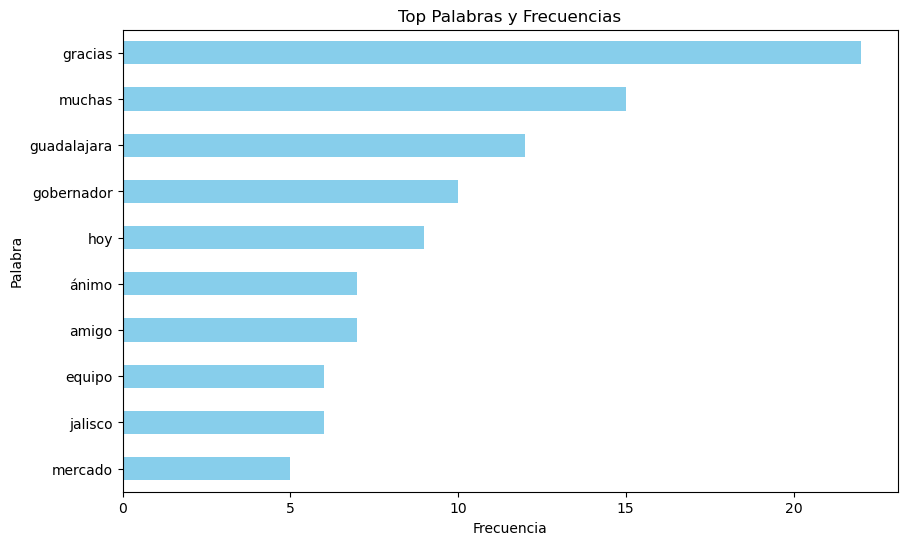

In [15]:
# Crear el gráfico de barras horizontal
plt.figure(figsize=(10, 6))
top_words.plot(kind='barh', color='skyblue')
plt.xlabel('Frecuencia')
plt.ylabel('Palabra')
plt.title('Top Palabras y Frecuencias')
plt.gca().invert_yaxis()  # Invertir el eje y para mostrar la palabra con la frecuencia más alta en la parte superior
plt.show()

In [16]:
tweets_tidy.tokens

0      [visitamos, el, oriente, de, la, ciudad, para,...
1            [este, nido, captará, el, agua, de, lluvia]
2                                         [agradezco, a]
3      [ahora, más, calles, de, nuestra, ciudad, tien...
4                                [adoquín, podo, táctil]
                             ...                        
108                                  [gracias, estimado]
109                              [gracias, por, asistir]
110                          [muchas, gracias, estimada]
111     [un, honor, tenerte, de, nuevo, en, guadalajara]
112    [muchas, gracias, amigo, y, gobernador, de, yu...
Name: tokens, Length: 113, dtype: object

In [17]:
texts = tweets_tidy.tokens

punctuation = set(string.punctuation)

texts = [[word for word in doc if word not in stop_words and word not in punctuation] for doc in texts]

# Crear un diccionario de términos a partir del corpus
dictionary = corpora.Dictionary(texts)

# Crear una representación vectorial del corpus
corpus = [dictionary.doc2bow(text) for text in texts]

In [20]:
# Entrenar el modelo LDA
lda_model = LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)

# Obtener los temas y sus palabras clave
topics = lda_model.print_topics(num_words=10)

# Mostrar los temas y sus palabras clave
for topic in topics:
    print(topic)

(0, '0.083*"gracias" + 0.042*"muchas" + 0.024*"amigo" + 0.020*"reconocimiento" + 0.017*"gobernador" + 0.017*"acompañarme" + 0.013*"estimado" + 0.009*"guadalajara" + 0.009*"compromiso" + 0.009*"honor"')
(1, '0.023*"hoy" + 0.019*"gobernador" + 0.016*"acompañamos" + 0.012*"mercado" + 0.008*"autoridades" + 0.008*"año" + 0.008*"corrupción" + 0.008*"lluvia" + 0.008*"hicimos" + 0.008*"cumpleaños"')
(2, '0.024*"muchas" + 0.021*"felicidades" + 0.011*"guadalajara" + 0.011*"parte" + 0.011*"seguir" + 0.011*"vamos" + 0.011*"carreras" + 0.011*"días" + 0.006*"gusto" + 0.006*"ciudad"')
(3, '0.020*"guadalajara" + 0.014*"avenida" + 0.014*"día" + 0.011*"escolares" + 0.011*"equipo" + 0.011*"escuela" + 0.007*"ánimo" + 0.007*"hoy" + 0.007*"programa" + 0.007*"haciendo"')
(4, '0.012*"jalisco" + 0.012*"trabajo" + 0.012*"ánimo" + 0.008*"través" + 0.008*"tapatíos" + 0.008*"dirección" + 0.008*"personas" + 0.008*"discapacidad" + 0.008*"disfrutar" + 0.008*"mercado"')


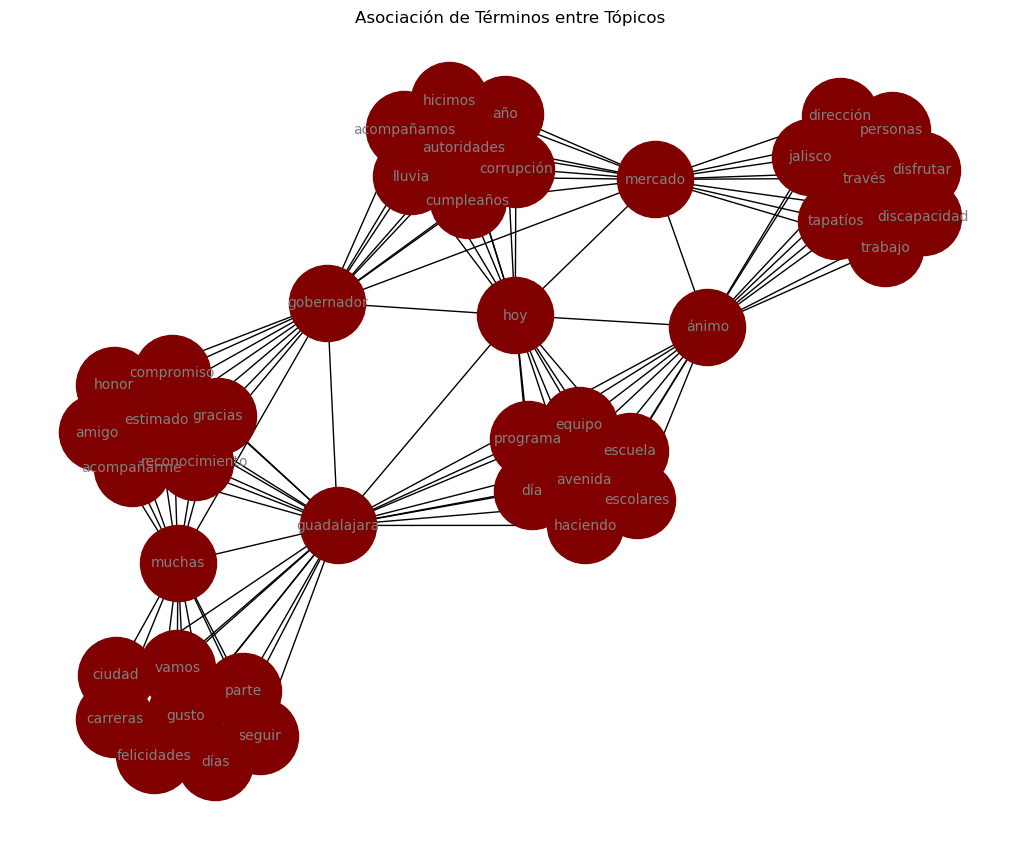

In [21]:
import networkx as nx

# Crear un grafo de red
G = nx.Graph()

# Procesar los tópicos y sus palabras clave para identificar asociaciones
for topic_id, topic_words in topics:
    # Dividir las palabras clave en términos individuales
    terms = [term.split('*')[1].strip('"') for term in topic_words.split(' + ')]
    
    # Agregar una arista entre todos los términos del tópico
    for i in range(len(terms)):
        for j in range(i + 1, len(terms)):
            term1, term2 = terms[i], terms[j]
            G.add_edge(term1, term2, topic=topic_id)

# Dibujar el gráfico de red
pos = nx.spring_layout(G, k=0.3, iterations=50)
plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels=True, font_size=10, node_size=3000, node_color='maroon', font_color='gray')

# Mostrar el gráfico de red
plt.title('Asociación de Términos entre Tópicos')
# Guardar la figura como una imagen
plt.savefig('topicos.png', bbox_inches='tight', dpi=300)
plt.show()

# Opción " Topics

In [22]:
import spacy

nlp = spacy.load("es_core_news_sm")

# Función para preprocesar el texto
def preprocess_text(text):
    doc = nlp(text)
    return [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]

# Aplicar el preprocesamiento a cada fila del DataFrame
df_posts['texto_preprocesado'] = df_posts['texto'].apply(preprocess_text)
df_posts

,texto,tokens,texto_preprocesado
0,visitamos el oriente de la ciudad para una ent...,"[visitamos, el, oriente, de, la, ciudad, para,...","[visitar, oriente, ciudad, entrega, nido, lluvia]"
1,este nido captará el agua de lluvia,"[este, nido, captará, el, agua, de, lluvia]","[nido, captar, agua, lluvia]"
2,agradezco a,"[agradezco, a]",[agradecer]
3,ahora más calles de nuestra ciudad tienen un n...,"[ahora, más, calles, de, nuestra, ciudad, tien...","[calle, ciudad, rostro, lucir, bonito, digna, ..."
4,adoquín podo táctil,"[adoquín, podo, táctil]","[adoquín, podo, táctil]"
...,...,...,...
108,gracias estimado,"[gracias, estimado]","[gracia, estimado]"
109,gracias por asistir,"[gracias, por, asistir]","[gracia, asistir]"
110,muchas gracias estimada,"[muchas, gracias, estimada]","[gracia, estimar]"
111,un honor tenerte de nuevo en guadalajara,"[un, honor, tenerte, de, nuevo, en, guadalajara]","[honor, tenerte, guadalajara]"


In [23]:
from gensim import corpora

# Crear un diccionario a partir de los documentos preprocesados
dictionary = corpora.Dictionary(df_posts['texto_preprocesado'])

# Crear una representación BoW de los documentos
corpus = [dictionary.doc2bow(texto) for texto in df_posts['texto_preprocesado']]

In [24]:
from gensim.models import LdaModel

num_topics = 5  # Ajusta el número de tópicos según tus necesidades
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)

In [26]:
# Obtener los temas y sus palabras clave
topics = lda_model.print_topics(num_words=10)

# Mostrar los temas y sus palabras clave
for topic in topics:
    print(topic)

(0, '0.026*"guadalajara" + 0.021*"felicidad" + 0.016*"año" + 0.011*"organizado" + 0.011*"colaboración" + 0.011*"iberoamericano" + 0.006*"jalisco" + 0.006*"honor" + 0.006*"querido" + 0.006*"felicitación"')
(1, '0.018*"equipo" + 0.018*"escuela" + 0.018*"trabajar" + 0.012*"poder" + 0.012*"disfrutar" + 0.007*"compromiso" + 0.007*"ánimo" + 0.007*"escolar" + 0.007*"ciudad" + 0.007*"ayudar"')
(2, '0.022*"mercado" + 0.013*"jalisco" + 0.013*"programa" + 0.013*"trabajo" + 0.013*"reconocimiento" + 0.010*"gracia" + 0.009*"cocina" + 0.009*"espacio" + 0.009*"público" + 0.009*"lluvia"')
(3, '0.073*"gracia" + 0.028*"gobernador" + 0.023*"ánimo" + 0.023*"amigo" + 0.019*"acompañar yo" + 0.014*"acompañar" + 0.014*"agradecer" + 0.014*"estimado" + 0.010*"familia" + 0.010*"padre"')
(4, '0.019*"avenida" + 0.014*"gobernador" + 0.014*"resultado" + 0.014*"guadalajara" + 0.014*"gusto" + 0.010*"amigo" + 0.010*"trabajar" + 0.010*"reconocimiento" + 0.010*"ciudadano" + 0.010*"seguridad"')


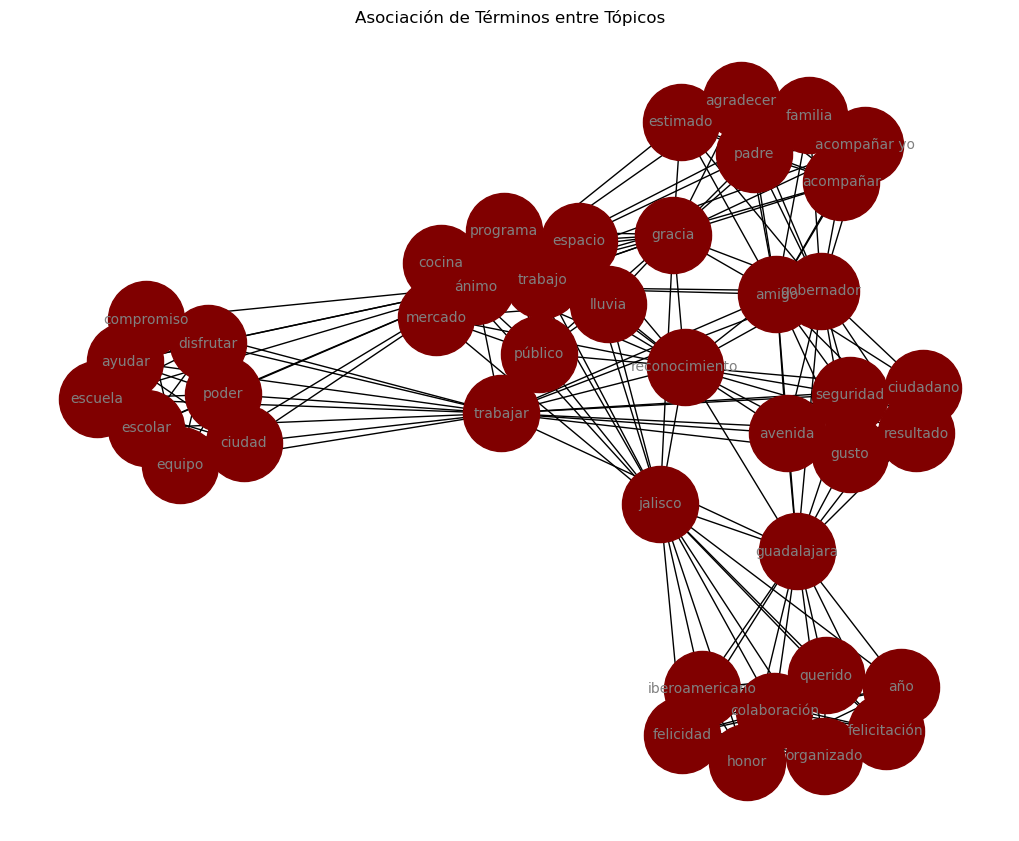

In [27]:
import networkx as nx

# Crear un grafo de red
G = nx.Graph()

# Procesar los tópicos y sus palabras clave para identificar asociaciones
for topic_id, topic_words in topics:
    # Dividir las palabras clave en términos individuales
    terms = [term.split('*')[1].strip('"') for term in topic_words.split(' + ')]
    
    # Agregar una arista entre todos los términos del tópico
    for i in range(len(terms)):
        for j in range(i + 1, len(terms)):
            term1, term2 = terms[i], terms[j]
            G.add_edge(term1, term2, topic=topic_id)

# Dibujar el gráfico de red
pos = nx.spring_layout(G, k=0.3, iterations=50)
plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels=True, font_size=10, node_size=3000, node_color='maroon', font_color='gray')

# Mostrar el gráfico de red
plt.title('Asociación de Términos entre Tópicos')
# Guardar la figura como una imagen
plt.savefig('topicos.png', bbox_inches='tight', dpi=300)
plt.show()

In [28]:
import pandas as pd
import spacy
from nltk.util import ngrams
from nltk.tokenize import word_tokenize

# Generación de bigramas con spaCy
nlp = spacy.load("es_core_news_sm")

def generar_bigramas_spacy(texto):
    doc = nlp(texto)
    bigramas = [(doc[i].text, doc[i + 1].text) for i in range(len(doc) - 1)]
    return bigramas

df_posts_clean['bigramas_spacy'] = df_posts_clean['texto'].apply(generar_bigramas_spacy)

# Generación de bigramas con NLTK
def generar_bigramas_nltk(texto):
    tokens = word_tokenize(texto)
    bigramas = list(ngrams(tokens, 2))
    return bigramas

df_posts_clean['bigramas_nltk'] = df_posts_clean['texto'].apply(generar_bigramas_nltk)

# Visualización del DataFrame resultante
df_posts_clean


,texto,tokens,bigramas_spacy,bigramas_nltk
0,visitamos el oriente de la ciudad para una ent...,"[visitamos, el, oriente, de, la, ciudad, para,...","[(visitamos, el), (el, oriente), (oriente, de)...","[(visitamos, el), (el, oriente), (oriente, de)..."
1,este nido captará el agua de lluvia,"[este, nido, captará, el, agua, de, lluvia]","[(este, nido), (nido, captará), (captará, el),...","[(este, nido), (nido, captará), (captará, el),..."
2,agradezco a,"[agradezco, a]","[(agradezco, a)]","[(agradezco, a)]"
3,ahora más calles de nuestra ciudad tienen un n...,"[ahora, más, calles, de, nuestra, ciudad, tien...","[(ahora, más), (más, calles), (calles, de), (d...","[(ahora, más), (más, calles), (calles, de), (d..."
4,adoquín podo táctil,"[adoquín, podo, táctil]","[(adoquín, podo), (podo, táctil)]","[(adoquín, podo), (podo, táctil)]"
...,...,...,...,...
108,gracias estimado,"[gracias, estimado]","[(gracias, estimado)]","[(gracias, estimado)]"
109,gracias por asistir,"[gracias, por, asistir]","[(gracias, por), (por, asistir)]","[(gracias, por), (por, asistir)]"
110,muchas gracias estimada,"[muchas, gracias, estimada]","[(muchas, gracias), (gracias, estimada)]","[(muchas, gracias), (gracias, estimada)]"
111,un honor tenerte de nuevo en guadalajara,"[un, honor, tenerte, de, nuevo, en, guadalajara]","[(un, honor), (honor, tenerte), (tenerte, de),...","[(un, honor), (honor, tenerte), (tenerte, de),..."


In [29]:
import pandas as pd
import spacy

# Cargar el modelo de spaCy en español
nlp = spacy.load("es_core_news_sm")

# Función para lematizar el texto
def lematizar_texto(texto):
    doc = nlp(texto)
    lemas = [token.lemma_ for token in doc]
    return " ".join(lemas)

# Aplicar la función de lematización a cada fila del DataFrame
df_posts_clean['texto_lematizado'] = df_posts_clean['texto'].apply(lematizar_texto)

# Visualización del DataFrame resultante
df_posts_clean

,texto,tokens,bigramas_spacy,bigramas_nltk,texto_lematizado
0,visitamos el oriente de la ciudad para una ent...,"[visitamos, el, oriente, de, la, ciudad, para,...","[(visitamos, el), (el, oriente), (oriente, de)...","[(visitamos, el), (el, oriente), (oriente, de)...",visitar el oriente de el ciudad para uno entre...
1,este nido captará el agua de lluvia,"[este, nido, captará, el, agua, de, lluvia]","[(este, nido), (nido, captará), (captará, el),...","[(este, nido), (nido, captará), (captará, el),...",este nido captar el agua de lluvia
2,agradezco a,"[agradezco, a]","[(agradezco, a)]","[(agradezco, a)]",agradecer a
3,ahora más calles de nuestra ciudad tienen un n...,"[ahora, más, calles, de, nuestra, ciudad, tien...","[(ahora, más), (más, calles), (calles, de), (d...","[(ahora, más), (más, calles), (calles, de), (d...",ahora más calle de nuestro ciudad tener uno nu...
4,adoquín podo táctil,"[adoquín, podo, táctil]","[(adoquín, podo), (podo, táctil)]","[(adoquín, podo), (podo, táctil)]",adoquín podo táctil
...,...,...,...,...,...
108,gracias estimado,"[gracias, estimado]","[(gracias, estimado)]","[(gracias, estimado)]",gracia estimado
109,gracias por asistir,"[gracias, por, asistir]","[(gracias, por), (por, asistir)]","[(gracias, por), (por, asistir)]",gracia por asistir
110,muchas gracias estimada,"[muchas, gracias, estimada]","[(muchas, gracias), (gracias, estimada)]","[(muchas, gracias), (gracias, estimada)]",mucho gracia estimar
111,un honor tenerte de nuevo en guadalajara,"[un, honor, tenerte, de, nuevo, en, guadalajara]","[(un, honor), (honor, tenerte), (tenerte, de),...","[(un, honor), (honor, tenerte), (tenerte, de),...",uno honor tenerte de nuevo en guadalajara


In [30]:
# Aplicar el preprocesamiento a cada fila del DataFrame
df_posts_clean['texto_preprocesado'] = df_posts_clean['texto_lematizado'].apply(preprocess_text)

# Crear un diccionario a partir de los documentos preprocesados
dictionary = corpora.Dictionary(df_posts_clean['texto_preprocesado'])

# Crear una representación BoW de los documentos
corpus = [dictionary.doc2bow(texto) for texto in df_posts_clean['texto_preprocesado']]

num_topics = 5  # Ajusta el número de tópicos según tus necesidades
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)

# Obtener los temas y sus palabras clave
topics = lda_model.print_topics(num_words=10)

# Mostrar los temas y sus palabras clave
for topic in topics:
    print(topic)

(0, '0.075*"gracia" + 0.023*"mercado" + 0.020*"acompañar" + 0.018*"guadalajara" + 0.014*"jalisco" + 0.014*"ánimo" + 0.010*"felicitación" + 0.010*"seguir" + 0.010*"año" + 0.010*"apoyo"')
(1, '0.023*"felicidad" + 0.023*"agradecer" + 0.018*"querer" + 0.012*"ánimo" + 0.012*"gobierno" + 0.012*"amigo" + 0.012*"cocina" + 0.012*"disfrutar" + 0.007*"reconocimiento" + 0.007*"honor"')
(2, '0.017*"escuela" + 0.017*"colaboración" + 0.017*"gracias" + 0.012*"niña" + 0.012*"seguridad" + 0.012*"guadalajara" + 0.012*"niño" + 0.012*"autoridad" + 0.012*"escolar" + 0.012*"iberoamericano"')
(3, '0.034*"gobernador" + 0.019*"equipo" + 0.019*"trabajar" + 0.019*"amigo" + 0.014*"acompañar" + 0.012*"trabajo" + 0.012*"estimado" + 0.008*"ánimo" + 0.008*"familia" + 0.008*"guadalajara"')
(4, '0.023*"avenida" + 0.012*"dirección" + 0.012*"lázaro" + 0.012*"calzada" + 0.012*"rosa" + 0.012*"chapalitar" + 0.012*"plaza" + 0.012*"carrera" + 0.012*"nacional" + 0.007*"ciudad"')


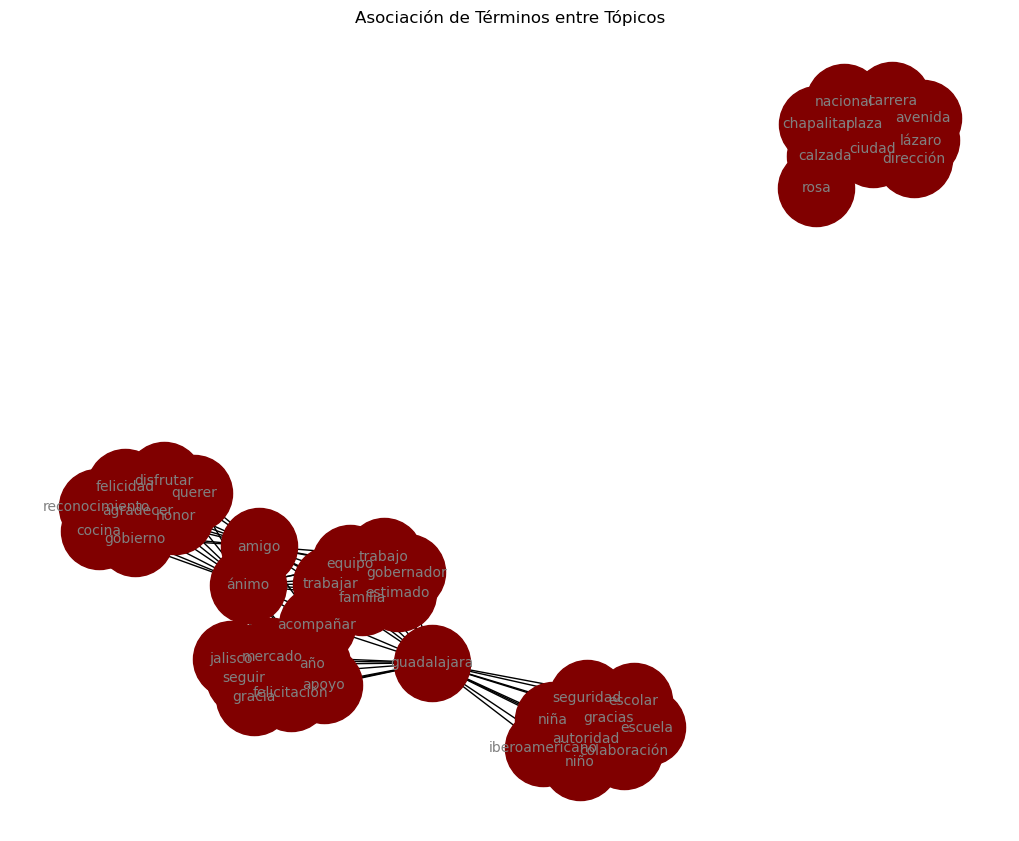

In [31]:
# Crear un grafo de red
G = nx.Graph()

# Procesar los tópicos y sus palabras clave para identificar asociaciones
for topic_id, topic_words in topics:
    # Dividir las palabras clave en términos individuales
    terms = [term.split('*')[1].strip('"') for term in topic_words.split(' + ')]
    
    # Agregar una arista entre todos los términos del tópico
    for i in range(len(terms)):
        for j in range(i + 1, len(terms)):
            term1, term2 = terms[i], terms[j]
            G.add_edge(term1, term2, topic=topic_id)

# Dibujar el gráfico de red
pos = nx.spring_layout(G, k=0.3, iterations=50)
plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels=True, font_size=10, node_size=3000, node_color='maroon', font_color='gray')

# Mostrar el gráfico de red
plt.title('Asociación de Términos entre Tópicos')
# Guardar la figura como una imagen
plt.savefig('topicos.png', bbox_inches='tight', dpi=300)
plt.show()

In [32]:
import networkx as nx
import plotly.graph_objects as go

# Crear un grafo de NetworkX
G = nx.Graph()

# Procesar los tópicos y sus palabras clave para identificar asociaciones
for topic_id, topic_words in topics:
    # Dividir las palabras clave en términos individuales
    terms = [term.split('*')[1].strip('"') for term in topic_words.split(' + ')]
    
    # Agregar una arista entre todos los términos del tópico
    for i in range(len(terms)):
        for j in range(i + 1, len(terms)):
            term1, term2 = terms[i], terms[j]
            G.add_edge(term1, term2, topic=topic_id)

# Obtener las posiciones de los nodos en el gráfico
pos = nx.spring_layout(G, k=0.3, iterations=50)

# Extraer las posiciones X e Y de los nodos
pos_x = {node: pos[node][0] for node in G.nodes}
pos_y = {node: pos[node][1] for node in G.nodes}

# Crear un objeto de grafo de Plotly
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos_x[edge[0]], pos_y[edge[0]]
    x1, y1 = pos_x[edge[1]], pos_y[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = list(pos_x.values())
node_y = list(pos_y.values())

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=False,
        colorscale='YlGnBu',
        size=10,
        colorbar=dict(thickness=15, title='Node Connections'),
        line_width=2))

node_adjacencies = []
node_text = []
for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    node_text.append('# de conexiones: ' + str(len(adjacencies[1])))

node_trace.marker.color = node_adjacencies
node_trace.text = node_text

# Crear la figura de Plotly
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                showlegend=False,
                hovermode='closest',
                margin=dict(b=0, l=0, r=0, t=0),
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

# Mostrar la figura
fig.update_layout(title='Asociación de Términos entre Tópicos', title_x=0.5)
fig.show()


In [34]:
# Crear un conjunto de términos únicos
unique_terms = set()
for topic_id, topic_words in topics:
    terms = [term.split('*')[1].strip('"') for term in topic_words.split(' + ')]
    unique_terms.update(terms)

# Crear listas para nodos y enlaces
nodes = list(unique_terms)
source_indices = []
target_indices = []
values = []

# Procesar los tópicos y sus palabras clave para identificar las conexiones
for topic_id, topic_words in topics:
    terms = [term.split('*')[1].strip('"') for term in topic_words.split(' + ')]
    for term in terms:
        source_indices.append(nodes.index(term))
        target_indices.append(len(nodes) + topic_id)  # Cada tema se representa como un nodo adicional
        values.append(1)

# Crear un diagrama de Sankey
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=nodes  # Etiquetas de los términos
    ),
    link=dict(
        source=source_indices,
        target=target_indices,
        value=values
    )
))

# Mostrar el diagrama de Sankey
fig.update_layout(title_text="Diagrama de Sankey de Tópicos y Términos")
fig.show()